# 04 - Classificando patologias em toras usando combinação de `LBP + SVM` e normalizando amostras pelo maior elemento do histograma

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pelo maior elemento do histograma
    arr /= arr.max()

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/lbp_norm2_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.493503,0.163741,0.020200,0.119668,0.025486,0.170752,0.022704,0.128906,0.025236,0.072090,...,0.111600,0.038953,0.141231,0.032943,0.107649,0.039732,0.144709,0.589939,1.0,0
1,0.530383,0.177368,0.024505,0.127775,0.024242,0.181861,0.023746,0.132443,0.021383,0.059658,...,0.110155,0.033402,0.149742,0.036436,0.105779,0.031827,0.152105,0.564981,1.0,0
2,0.496842,0.204401,0.020887,0.095297,0.025264,0.213037,0.021592,0.097383,0.024412,0.069475,...,0.086866,0.041803,0.174789,0.034693,0.079199,0.039041,0.176317,0.577274,1.0,0
3,0.504942,0.188577,0.023268,0.111324,0.026471,0.193842,0.022647,0.116538,0.022722,0.064490,...,0.100472,0.035659,0.171989,0.033648,0.101018,0.033946,0.167668,0.581152,1.0,0
4,0.518606,0.202488,0.022240,0.119850,0.025720,0.205968,0.022803,0.117853,0.023801,0.064160,...,0.103163,0.031863,0.178559,0.029559,0.106900,0.032989,0.177714,0.566080,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.490882,0.212913,0.021193,0.100049,0.024643,0.210448,0.019714,0.090685,0.026614,0.098078,...,0.078364,0.028586,0.165106,0.027600,0.082799,0.037457,0.166092,0.577624,1.0,3
356,0.504471,0.160240,0.023750,0.119044,0.025070,0.159947,0.022724,0.116698,0.022431,0.074183,...,0.114060,0.031227,0.134878,0.029908,0.111274,0.030201,0.130479,0.559742,1.0,3
357,0.505766,0.189622,0.020179,0.115311,0.023382,0.199231,0.017617,0.106983,0.021140,0.081358,...,0.106342,0.039398,0.151185,0.024343,0.096092,0.038757,0.155029,0.540359,1.0,3
358,0.499881,0.175243,0.021698,0.106948,0.026085,0.174769,0.022884,0.101257,0.020868,0.081575,...,0.110979,0.032725,0.148210,0.028219,0.102680,0.036163,0.156035,0.564975,1.0,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 1891
              precision    recall  f1-score   support

      normal       0.87      0.87      0.87        30
       broca       0.77      0.34      0.48        29
     fissura       0.59      0.85      0.70        26
       musgo       0.79      0.96      0.86        23

    accuracy                           0.74       108
   macro avg       0.75      0.75      0.73       108
weighted avg       0.76      0.74      0.72       108



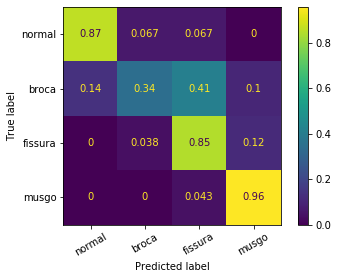

Rodada 1	-	Seed 4938
              precision    recall  f1-score   support

      normal       0.83      0.79      0.81        24
       broca       0.72      0.67      0.69        27
     fissura       0.77      0.77      0.77        30
       musgo       0.87      0.96      0.91        27

    accuracy                           0.80       108
   macro avg       0.79      0.80      0.79       108
weighted avg       0.79      0.80      0.79       108



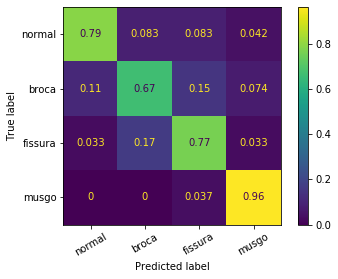

Rodada 2	-	Seed 2532
              precision    recall  f1-score   support

      normal       0.89      0.83      0.86        30
       broca       0.83      0.52      0.64        29
     fissura       0.60      0.96      0.74        25
       musgo       0.95      0.88      0.91        24

    accuracy                           0.79       108
   macro avg       0.82      0.80      0.79       108
weighted avg       0.82      0.79      0.78       108



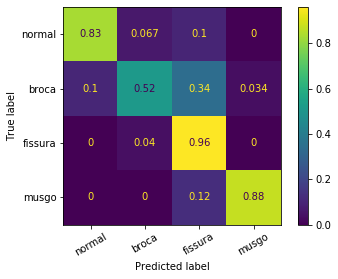

Rodada 3	-	Seed 5664
              precision    recall  f1-score   support

      normal       0.77      0.92      0.84        26
       broca       0.93      0.44      0.60        32
     fissura       0.67      0.92      0.77        26
       musgo       0.92      1.00      0.96        24

    accuracy                           0.80       108
   macro avg       0.82      0.82      0.79       108
weighted avg       0.83      0.80      0.78       108



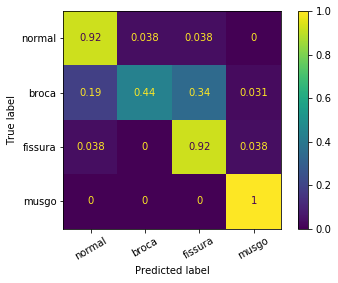

Rodada 4	-	Seed 5249
              precision    recall  f1-score   support

      normal       1.00      0.88      0.94        34
       broca       0.55      0.89      0.68        19
     fissura       0.83      0.65      0.73        31
       musgo       0.96      0.92      0.94        24

    accuracy                           0.82       108
   macro avg       0.83      0.83      0.82       108
weighted avg       0.86      0.82      0.83       108



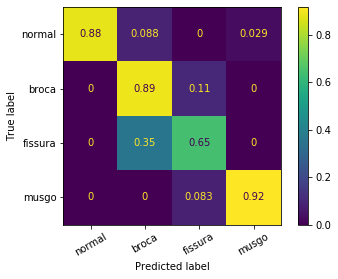

Rodada 5	-	Seed 4275
              precision    recall  f1-score   support

      normal       0.76      0.89      0.82        28
       broca       0.79      0.39      0.52        28
     fissura       0.55      0.71      0.62        24
       musgo       0.87      0.93      0.90        28

    accuracy                           0.73       108
   macro avg       0.74      0.73      0.71       108
weighted avg       0.75      0.73      0.72       108



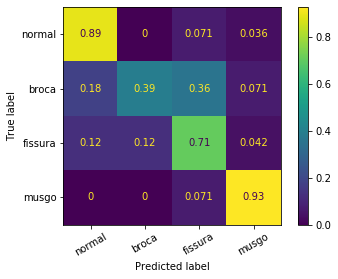

Rodada 6	-	Seed 3480
              precision    recall  f1-score   support

      normal       0.67      0.70      0.68        20
       broca       0.67      0.75      0.71        24
     fissura       0.86      0.63      0.73        30
       musgo       0.87      0.97      0.92        34

    accuracy                           0.78       108
   macro avg       0.77      0.76      0.76       108
weighted avg       0.78      0.78      0.77       108



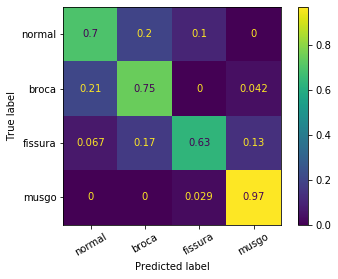

Rodada 7	-	Seed 6666
              precision    recall  f1-score   support

      normal       0.74      1.00      0.85        17
       broca       0.71      0.67      0.69        30
     fissura       0.83      0.69      0.75        35
       musgo       0.89      0.96      0.93        26

    accuracy                           0.80       108
   macro avg       0.79      0.83      0.80       108
weighted avg       0.80      0.80      0.79       108



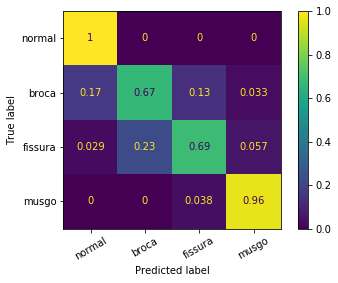

Rodada 8	-	Seed 1925
              precision    recall  f1-score   support

      normal       0.90      0.90      0.90        31
       broca       0.76      0.46      0.58        28
     fissura       0.66      0.92      0.77        25
       musgo       0.92      0.96      0.94        24

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.80       108
weighted avg       0.81      0.81      0.80       108



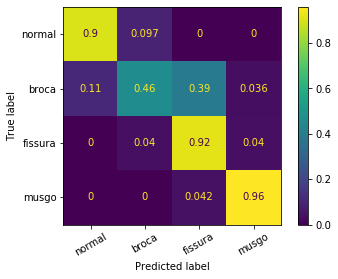

Rodada 9	-	Seed 1275
              precision    recall  f1-score   support

      normal       0.73      0.70      0.72        27
       broca       0.65      0.65      0.65        26
     fissura       0.70      0.76      0.73        25
       musgo       0.93      0.90      0.92        30

    accuracy                           0.76       108
   macro avg       0.75      0.75      0.75       108
weighted avg       0.76      0.76      0.76       108



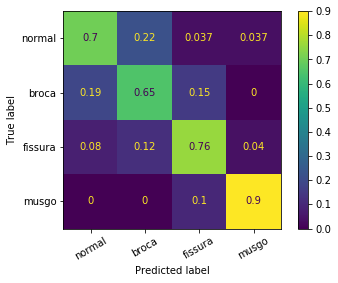

Rodada 10	-	Seed 812
              precision    recall  f1-score   support

      normal       0.87      0.84      0.86        32
       broca       0.67      0.48      0.56        25
     fissura       0.61      0.70      0.66        27
       musgo       0.75      0.88      0.81        24

    accuracy                           0.73       108
   macro avg       0.73      0.73      0.72       108
weighted avg       0.73      0.73      0.73       108



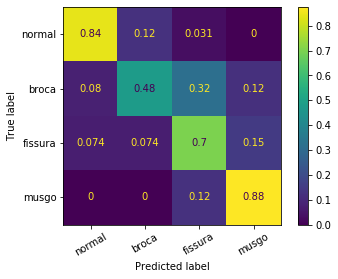

Rodada 11	-	Seed 1488
              precision    recall  f1-score   support

      normal       0.90      0.96      0.93        27
       broca       0.75      0.67      0.71        27
     fissura       0.67      0.77      0.71        26
       musgo       1.00      0.89      0.94        28

    accuracy                           0.82       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.83      0.82      0.83       108



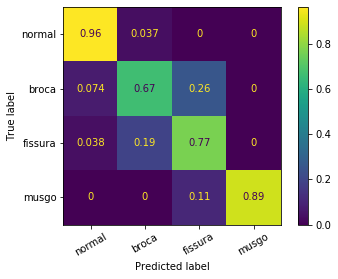

Rodada 12	-	Seed 4707
              precision    recall  f1-score   support

      normal       0.77      0.89      0.83        19
       broca       0.52      0.46      0.49        28
     fissura       0.59      0.59      0.59        32
       musgo       0.86      0.86      0.86        29

    accuracy                           0.69       108
   macro avg       0.69      0.70      0.69       108
weighted avg       0.68      0.69      0.68       108



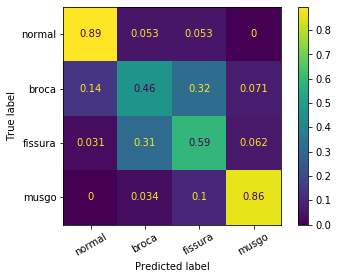

Rodada 13	-	Seed 2940
              precision    recall  f1-score   support

      normal       0.85      0.83      0.84        35
       broca       0.62      0.62      0.62        21
     fissura       0.92      0.79      0.85        29
       musgo       0.79      0.96      0.86        23

    accuracy                           0.81       108
   macro avg       0.79      0.80      0.79       108
weighted avg       0.81      0.81      0.81       108



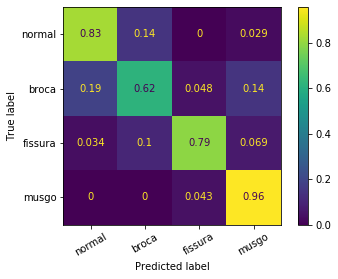

Rodada 14	-	Seed 3
              precision    recall  f1-score   support

      normal       0.81      0.79      0.80        33
       broca       0.46      0.58      0.51        19
     fissura       0.77      0.61      0.68        33
       musgo       0.81      0.91      0.86        23

    accuracy                           0.72       108
   macro avg       0.71      0.72      0.71       108
weighted avg       0.74      0.72      0.72       108



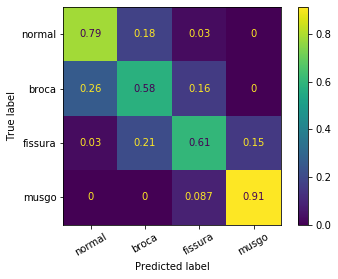

Rodada 15	-	Seed 6946
              precision    recall  f1-score   support

      normal       0.84      0.88      0.86        24
       broca       0.78      0.58      0.67        31
     fissura       0.67      0.88      0.76        25
       musgo       0.93      0.89      0.91        28

    accuracy                           0.80       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.81      0.80      0.79       108



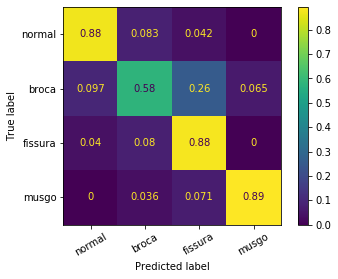

Rodada 16	-	Seed 1381
              precision    recall  f1-score   support

      normal       0.83      0.97      0.90        31
       broca       0.89      0.59      0.71        27
     fissura       0.70      0.76      0.73        21
       musgo       0.90      0.97      0.93        29

    accuracy                           0.83       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.84      0.83      0.83       108



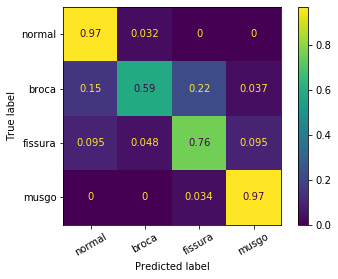

Rodada 17	-	Seed 7266
              precision    recall  f1-score   support

      normal       0.82      0.67      0.73        27
       broca       0.57      0.50      0.53        26
     fissura       0.73      0.76      0.75        29
       musgo       0.79      1.00      0.88        26

    accuracy                           0.73       108
   macro avg       0.73      0.73      0.72       108
weighted avg       0.73      0.73      0.72       108



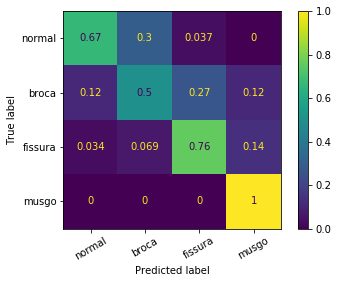

Rodada 18	-	Seed 4618
              precision    recall  f1-score   support

      normal       0.64      0.73      0.68        22
       broca       0.85      0.57      0.68        30
     fissura       0.73      0.83      0.77        29
       musgo       0.83      0.93      0.88        27

    accuracy                           0.76       108
   macro avg       0.76      0.76      0.75       108
weighted avg       0.77      0.76      0.75       108



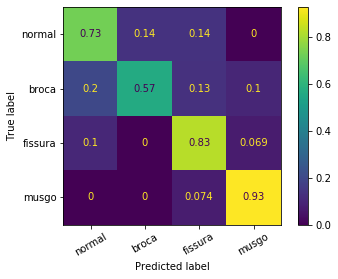

Rodada 19	-	Seed 3590
              precision    recall  f1-score   support

      normal       0.95      0.82      0.88        22
       broca       0.75      0.44      0.56        27
     fissura       0.54      0.86      0.67        29
       musgo       0.96      0.87      0.91        30

    accuracy                           0.75       108
   macro avg       0.80      0.75      0.75       108
weighted avg       0.79      0.75      0.75       108



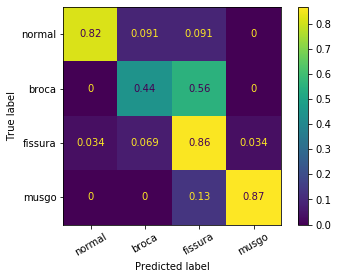

Rodada 20	-	Seed 6989
              precision    recall  f1-score   support

      normal       0.73      0.81      0.77        27
       broca       0.57      0.50      0.53        26
     fissura       0.75      0.77      0.76        31
       musgo       0.91      0.88      0.89        24

    accuracy                           0.74       108
   macro avg       0.74      0.74      0.74       108
weighted avg       0.74      0.74      0.74       108



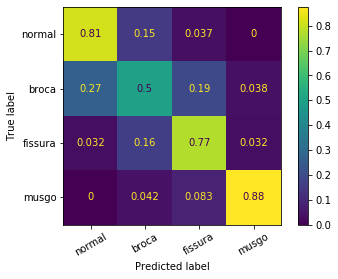

Rodada 21	-	Seed 6578
              precision    recall  f1-score   support

      normal       0.77      0.92      0.84        26
       broca       0.73      0.38      0.50        29
     fissura       0.55      0.77      0.64        22
       musgo       0.94      0.94      0.94        31

    accuracy                           0.75       108
   macro avg       0.75      0.75      0.73       108
weighted avg       0.76      0.75      0.74       108



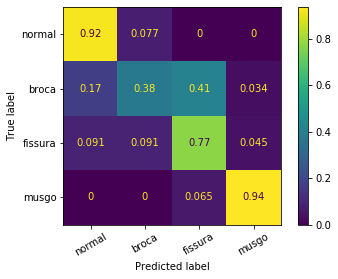

Rodada 22	-	Seed 3500
              precision    recall  f1-score   support

      normal       0.90      0.87      0.89        31
       broca       0.67      0.58      0.62        31
     fissura       0.59      0.70      0.64        27
       musgo       0.79      0.79      0.79        19

    accuracy                           0.73       108
   macro avg       0.74      0.74      0.73       108
weighted avg       0.74      0.73      0.73       108



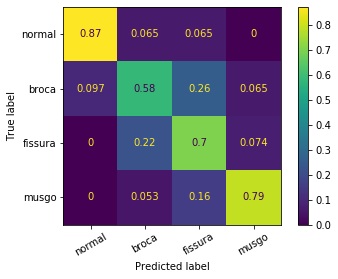

Rodada 23	-	Seed 6286
              precision    recall  f1-score   support

      normal       0.67      0.90      0.77        20
       broca       0.76      0.62      0.68        26
     fissura       0.83      0.73      0.77        33
       musgo       0.87      0.93      0.90        29

    accuracy                           0.79       108
   macro avg       0.78      0.79      0.78       108
weighted avg       0.79      0.79      0.78       108



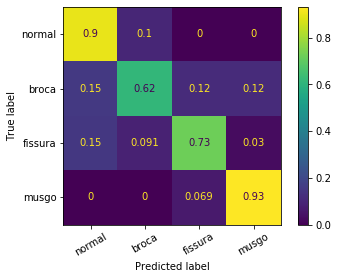

Rodada 24	-	Seed 986
              precision    recall  f1-score   support

      normal       0.84      0.93      0.89        29
       broca       0.67      0.80      0.73        20
     fissura       0.77      0.65      0.71        26
       musgo       0.93      0.85      0.89        33

    accuracy                           0.81       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.82      0.81      0.81       108



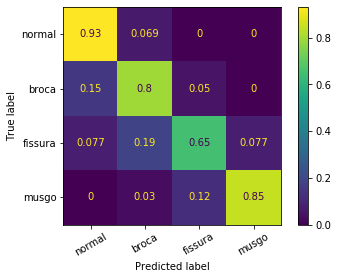

Rodada 25	-	Seed 7388
              precision    recall  f1-score   support

      normal       0.75      0.81      0.78        26
       broca       0.65      0.54      0.59        24
     fissura       0.64      0.58      0.61        31
       musgo       0.75      0.89      0.81        27

    accuracy                           0.70       108
   macro avg       0.70      0.70      0.70       108
weighted avg       0.70      0.70      0.70       108



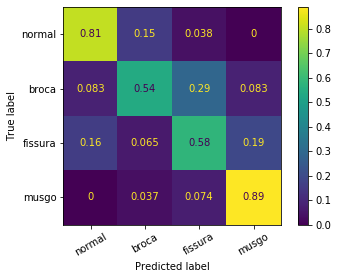

Rodada 26	-	Seed 6641
              precision    recall  f1-score   support

      normal       0.88      0.68      0.77        34
       broca       0.60      0.54      0.57        28
     fissura       0.70      0.91      0.79        23
       musgo       0.85      1.00      0.92        23

    accuracy                           0.76       108
   macro avg       0.76      0.78      0.76       108
weighted avg       0.76      0.76      0.75       108



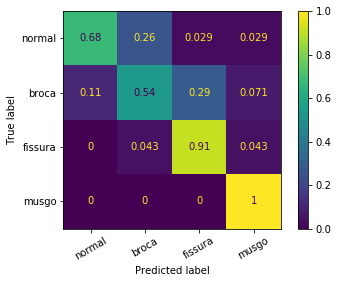

Rodada 27	-	Seed 4445
              precision    recall  f1-score   support

      normal       0.83      0.68      0.75        28
       broca       0.70      0.70      0.70        27
     fissura       0.66      0.78      0.71        27
       musgo       0.88      0.88      0.88        26

    accuracy                           0.76       108
   macro avg       0.77      0.76      0.76       108
weighted avg       0.77      0.76      0.76       108



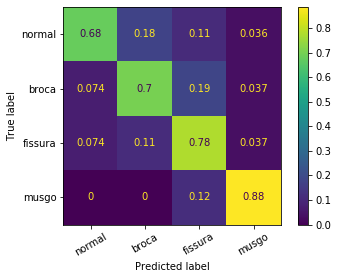

Rodada 28	-	Seed 4401
              precision    recall  f1-score   support

      normal       0.92      0.73      0.81        30
       broca       0.62      0.67      0.64        27
     fissura       0.81      0.81      0.81        27
       musgo       0.82      0.96      0.88        24

    accuracy                           0.79       108
   macro avg       0.79      0.79      0.79       108
weighted avg       0.80      0.79      0.79       108



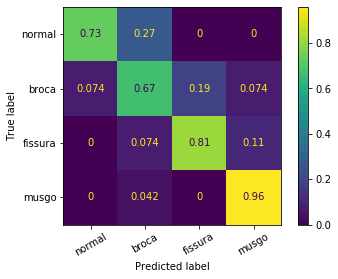

Rodada 29	-	Seed 858
              precision    recall  f1-score   support

      normal       0.93      0.86      0.89        29
       broca       0.65      0.71      0.68        24
     fissura       0.71      0.68      0.69        25
       musgo       0.90      0.93      0.92        30

    accuracy                           0.81       108
   macro avg       0.80      0.80      0.80       108
weighted avg       0.81      0.81      0.81       108



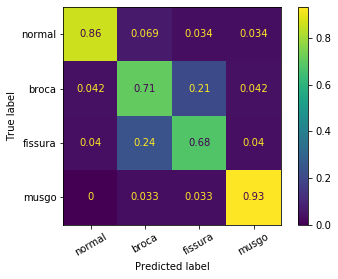

In [4]:
df = pd.read_csv('./csvs/lbp_norm2_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

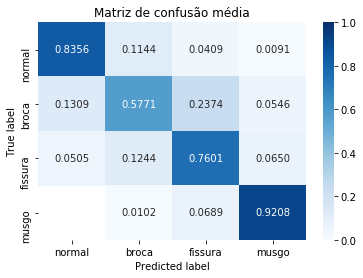

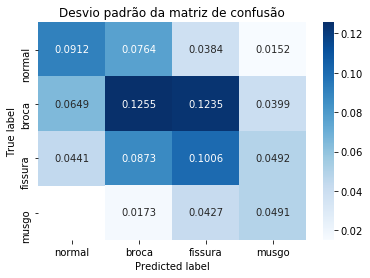

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal   f1-broca  f1-fissura   f1-musgo
count  30.000000  30.000000  30.000000   30.000000  30.000000
mean    0.769753   0.824639   0.616941    0.720671   0.895067
std     0.038117   0.068464   0.077158    0.061800   0.040758
min     0.685185   0.680851   0.476190    0.593750   0.789474
25%     0.740741   0.773392   0.558140    0.681944   0.878234
50%     0.768519   0.841342   0.629494    0.729021   0.904545
75%     0.796296   0.875203   0.680638    0.765476   0.919508
max     0.833333   0.937500   0.727273    0.851852   0.960000


Acurácia,f1-normal,f1-broca,f1-fissura,f1-musgo
0.740741,0.866667,0.476190,0.698413,0.862745
0.796296,0.808511,0.692308,0.766667,0.912281
0.787037,0.862069,0.638298,0.738462,0.913043
0.796296,0.842105,0.595745,0.774194,0.960000
0.824074,0.937500,0.680000,0.727273,0.936170
0.731481,0.819672,0.523810,0.618182,0.896552
0.777778,0.682927,0.705882,0.730769,0.916667
0.796296,0.850000,0.689655,0.750000,0.925926
0.805556,0.903226,0.577778,0.766667,0.938776
0.759259,0.716981,0.653846,0.730769,0.915254


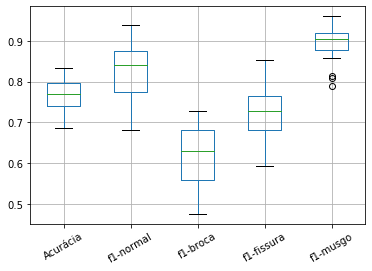

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')